# Homework2 outlines
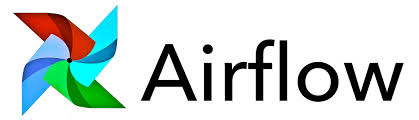

#### Task:
Create a data pipeline using Airflow that perform ETL jobs to extract data and put into a storage of your choice.

#### What I created
1. Scrape headlines of top news from [CBC](https://www.cbc.ca/news/canada)
2. Store them into a csv file with.

#### Table of contents
- Talk about more details of what I created.
    - Scraping
    - Writing CSV file
- Look at the code.
- How to use.
- Import csv to Pandas Dataframe
- What can we do with this
- Resources

## Talk about more details of what I created.

### Scraping
First of all, what it does is scrape the headlines of top news on [CBC](https://www.cbc.ca/news/canada) using [BeautifulSoap](https://www.crummy.com/software/BeautifulSoup/bs4/doc/), which is a Python library for web scraping.<br>
This is the top page of CBC at that time I am creating this Notebook, let's have a look at the headline of the left news where you can see Japanese flag. 
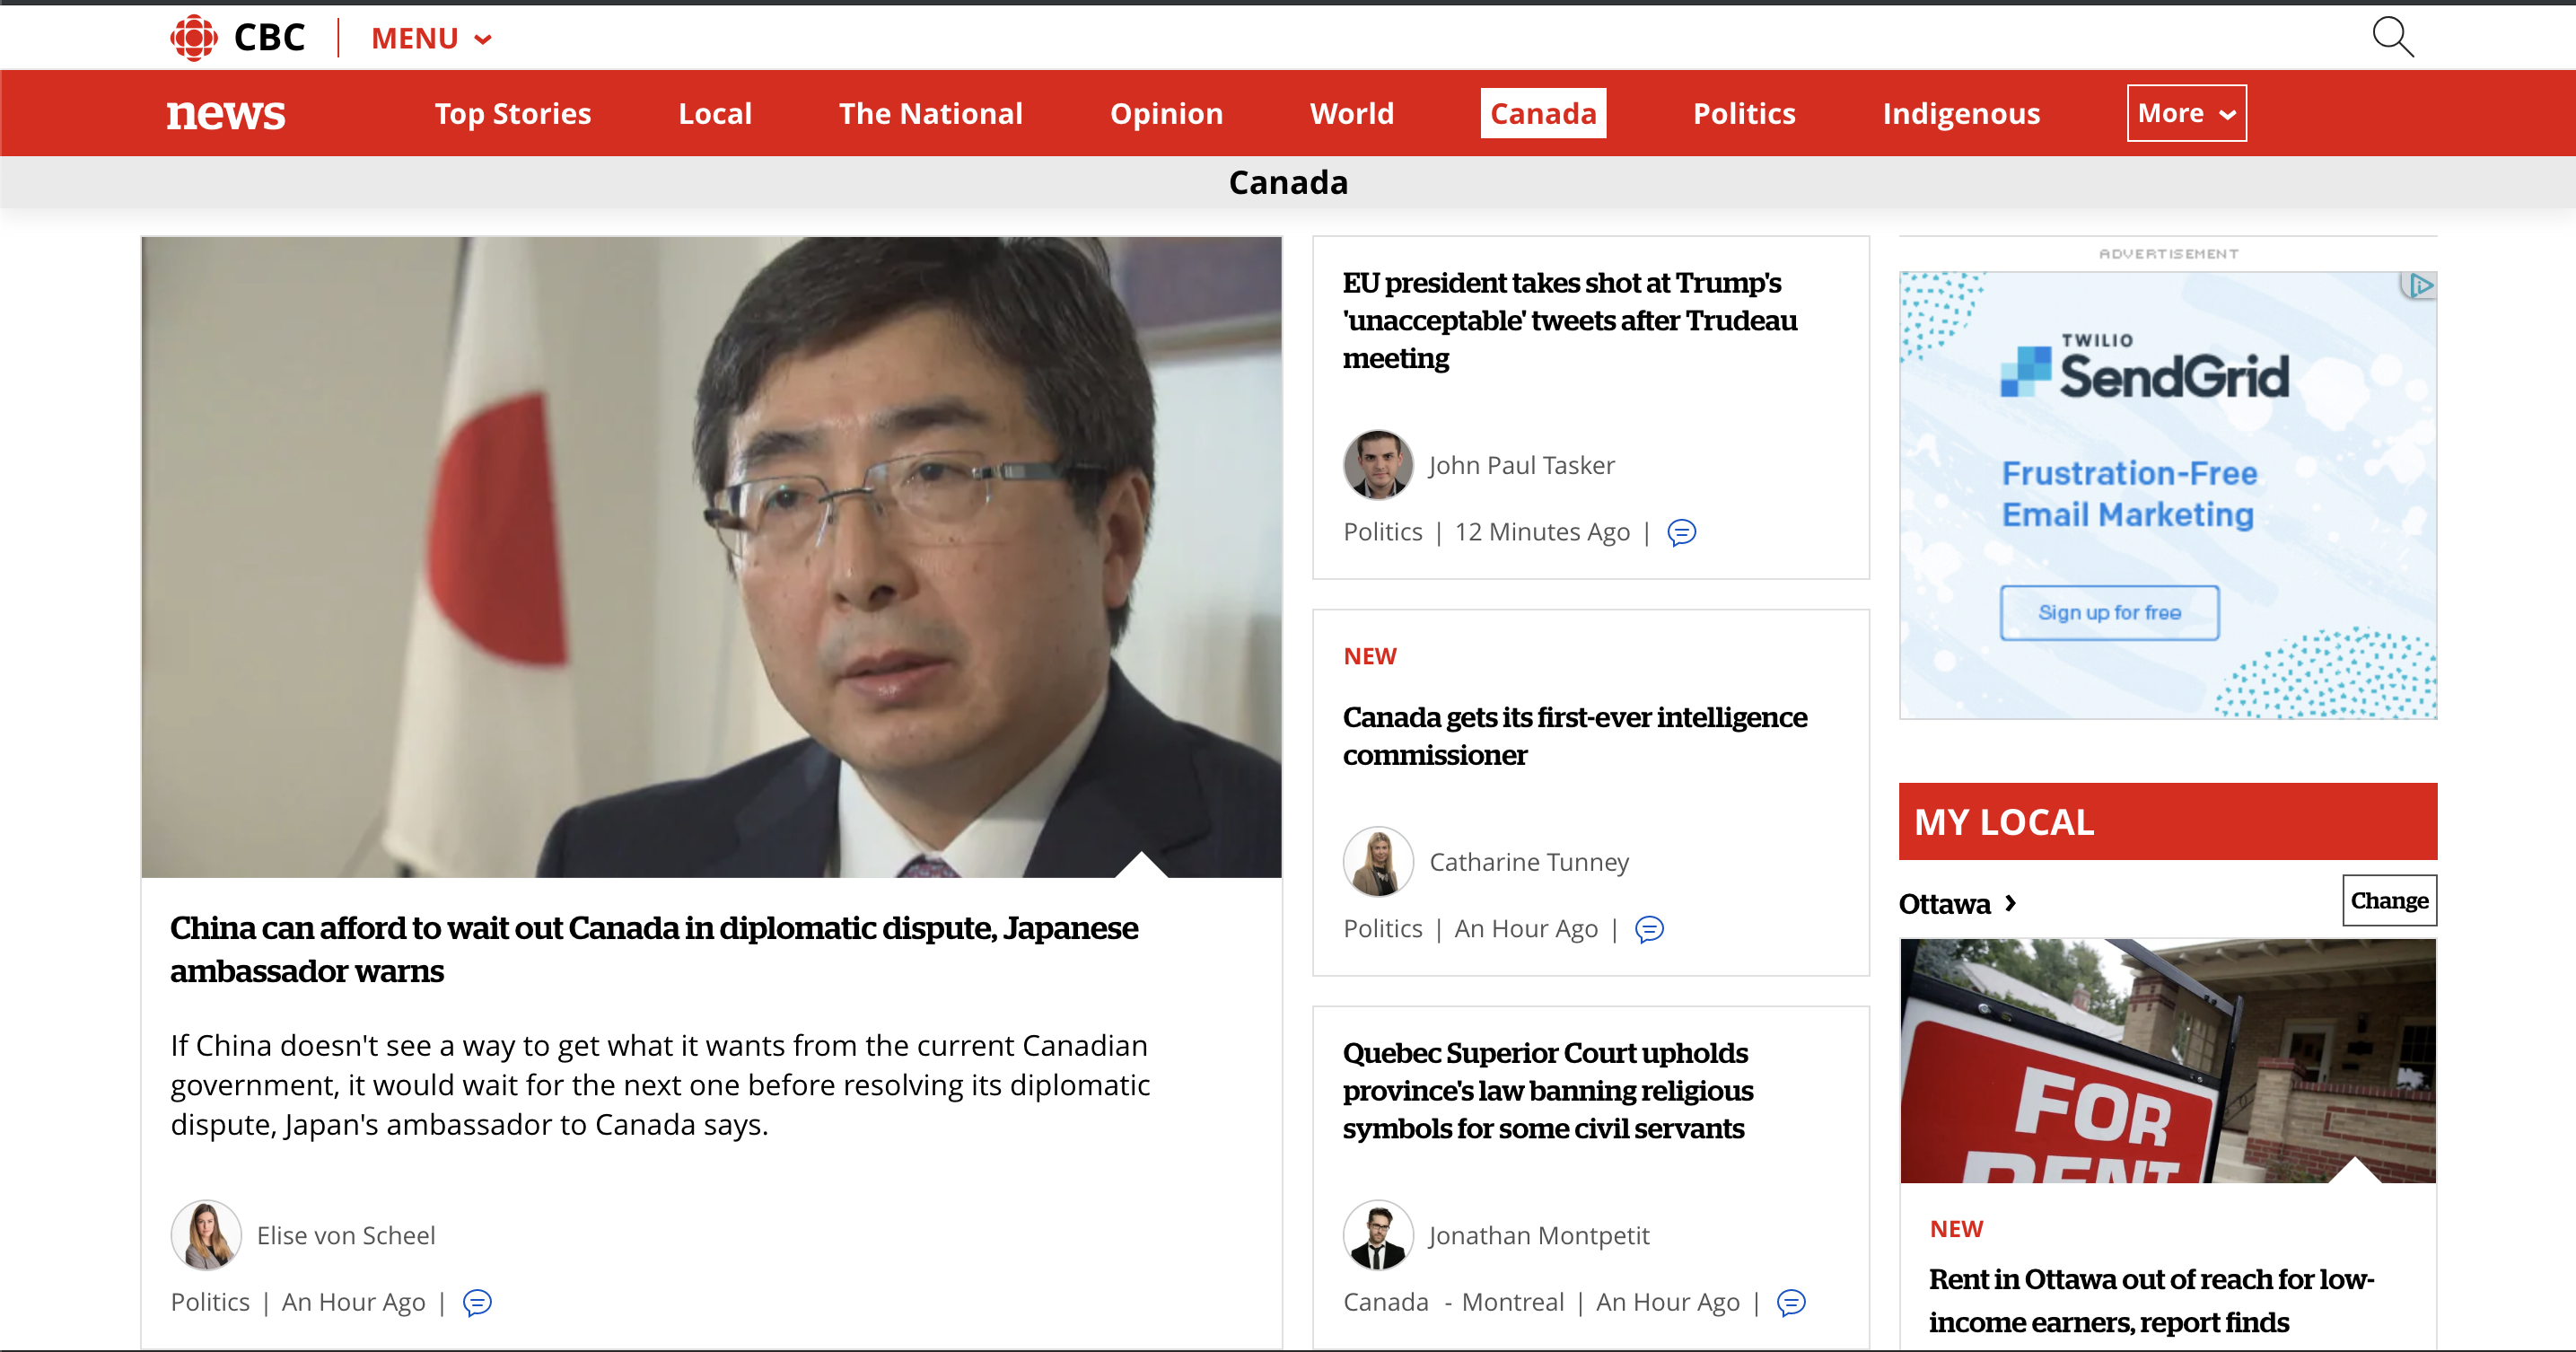
<br>
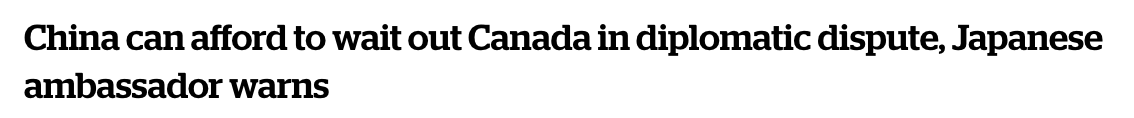
**This is a headline I am going to get.** On this website, every headline of news is inside of `<h3>` tag.

So we first scrape all of the text inside of `<h3>` tags on the top page but we need pay attention to things scraped.
```
avoid_words = ["My Local",
                       "Editor's Blog",
                       "Connect with CBC",
                       "Contact CBC",
                       "Services & Info",
                       "Accessibility"]
```
I created this list that contains words that the python script scrapes because those are also inside of `<h3>` tags but we don't want to write them into csv file.
In the picture below, you can find some of the words such as `Connect with CBC`, `Contact CBC`, etc.
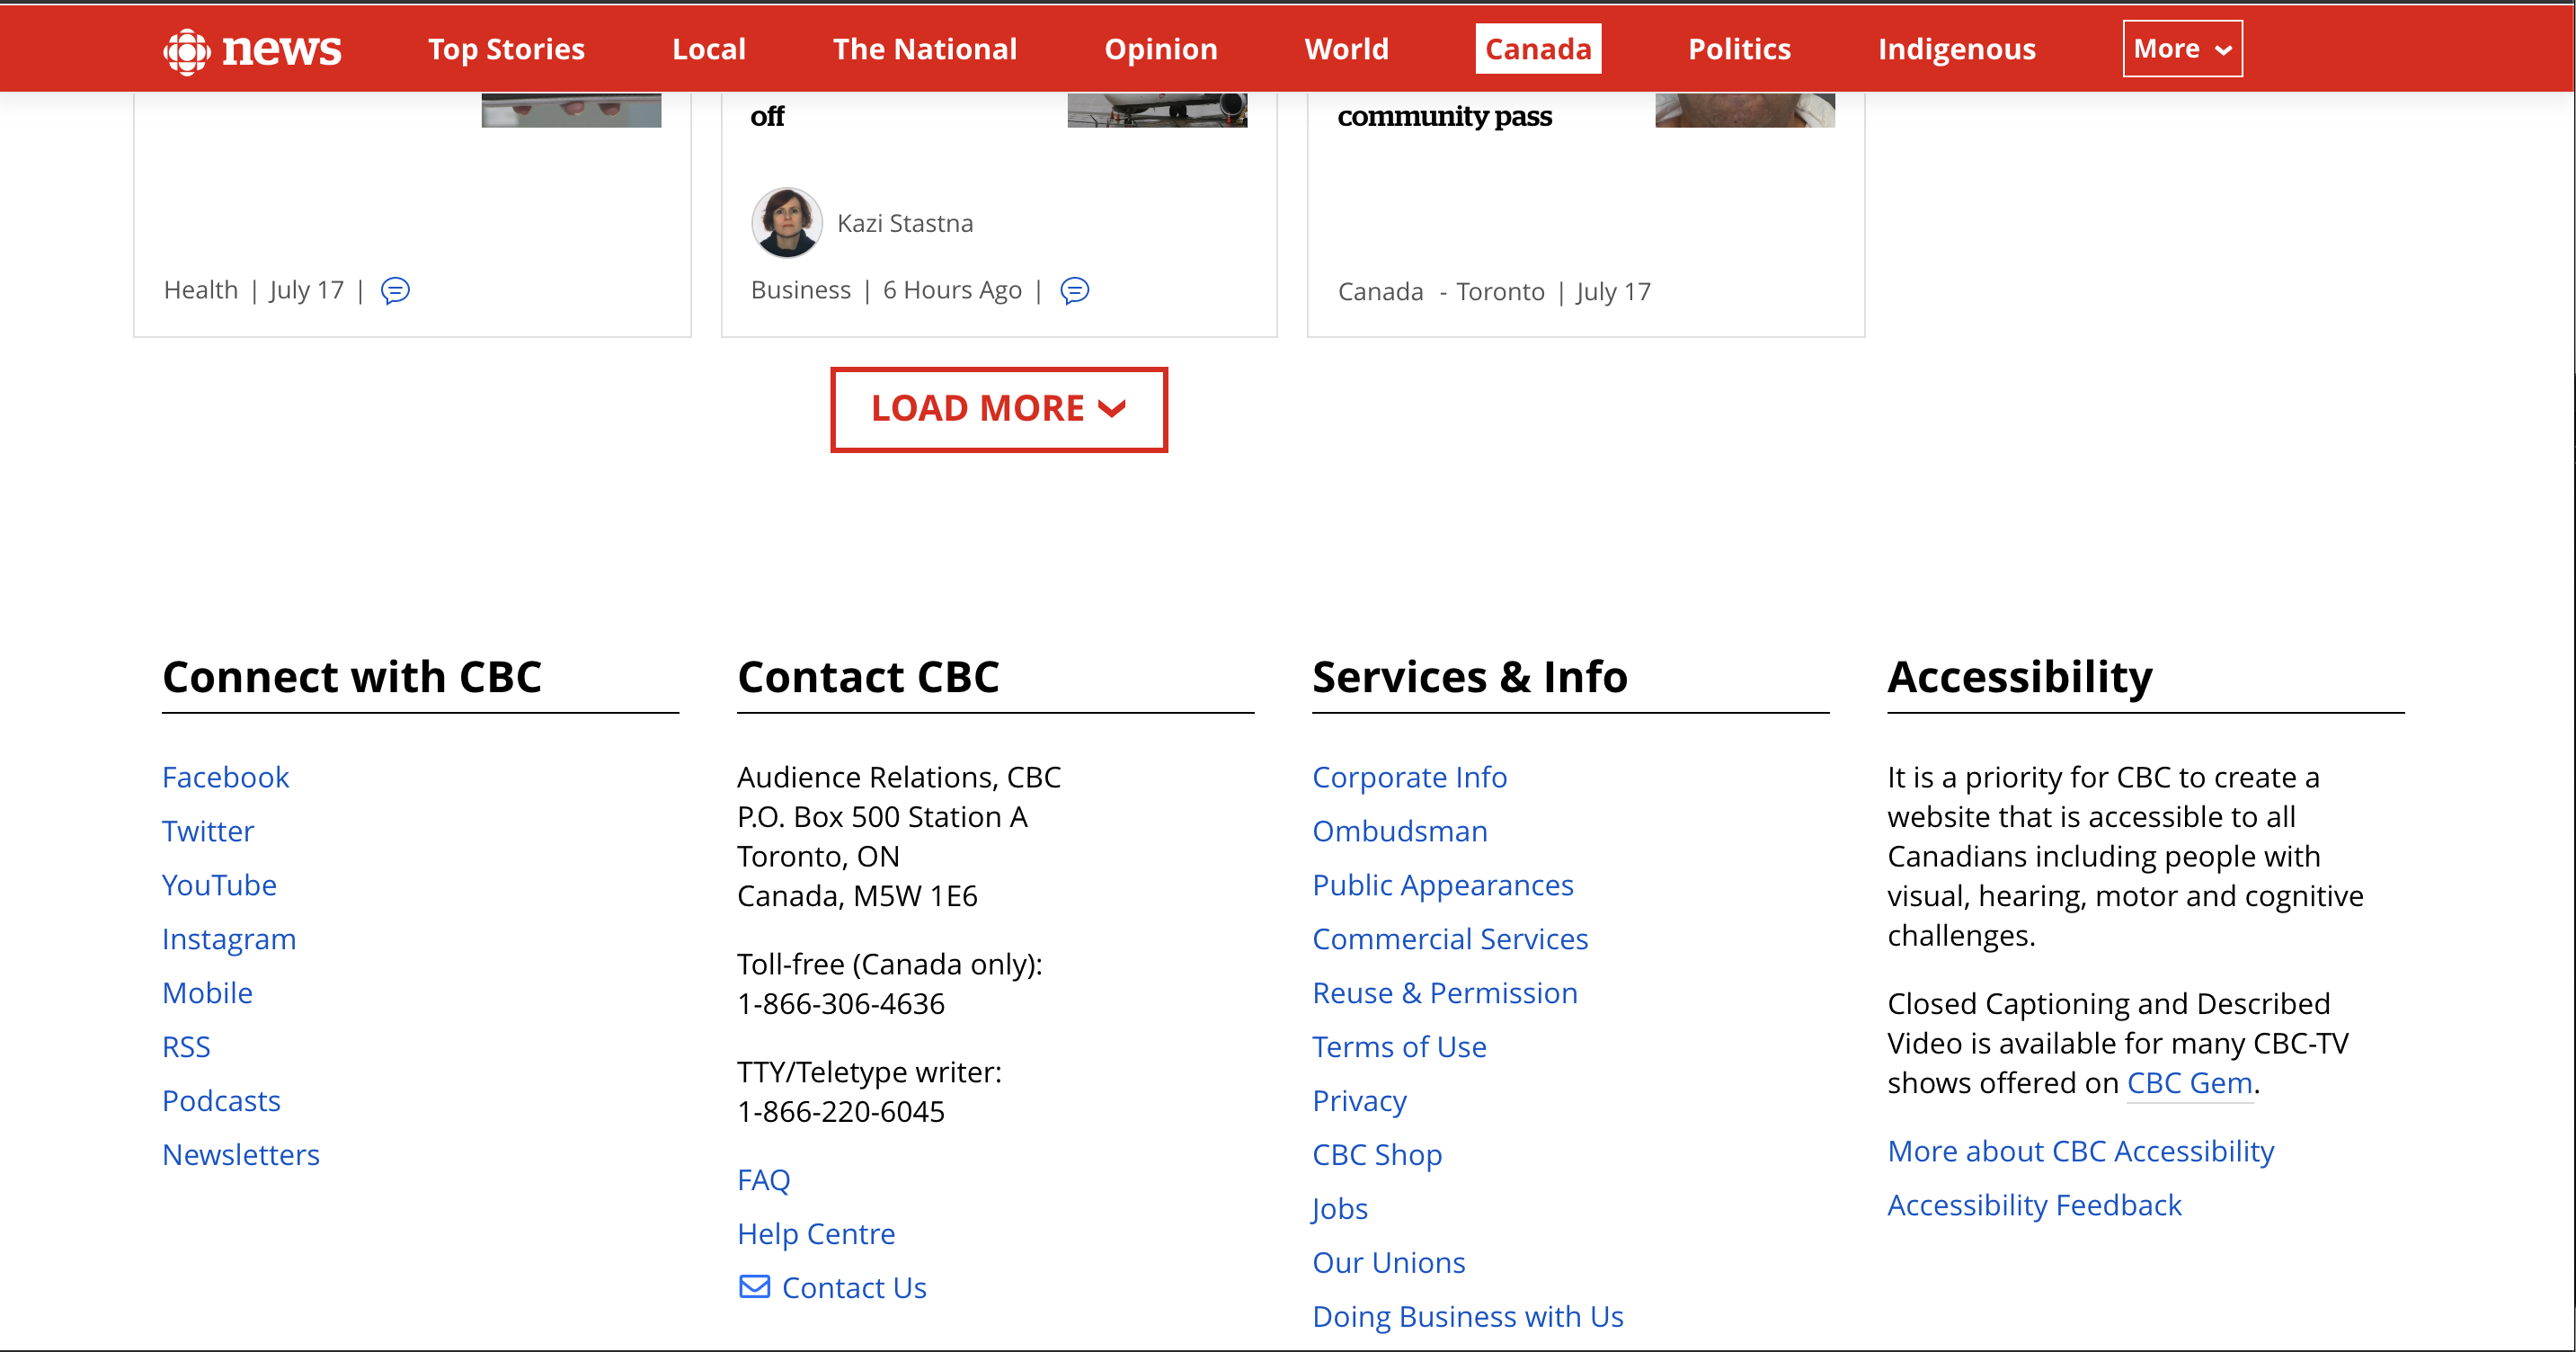
<br>
<br>
After scraping the headlines, it creates a 2 dimensional list that contains information below.
1. Headlines which we just scraped
2. Source url: where did we scrape from. (https://www.cbc.ca/news/canada)
3. Datetime

The reason why we create 2 dimensional list instead of 1 dimension is that it is convenient when we write them into csv file.

This list below is an example:<br>
```
list_example = [["Headline1", "https://www.cbc.ca/news/canada", "2019-07-16 15:29:00"],
                       ["Headline2", "https://www.cbc.ca/news/canada", "2019-07-16 15:29:00"],
                       :
                       :
                       :
                       ["HeadlineN", "https://www.cbc.ca/news/canada", "2019-07-16" 15:29:00]]
```

In [ ]:
def get_news_from_cbc(url):
    """
    Scrape headlines of news on https://www.cbc.ca/news/canada.
    Then write them into a csv file with additional information
    such as time and url.

    Parameters
    ----------
    url: str
    A URL to a website where I want to scrape from

    Returns
    -------
    current_top_news: list
    This is a list, and each element is also a list that contains
    1. headline
    2. source url
    3. date and time

    Example:
    [["headline1", "url", datetime],
     ["headline2", "url", datetime]]

    Where "headline" and "url" are string, datetime is datetime object.
    """
    response = requests.get(url)
    response.encoding = response.apparent_encoding

    bs = BeautifulSoup(response.text, 'html.parser')

    datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    current_top_news = []
    for i in bs.select("h3"):
        if not i.getText() in avoid_words:
            print(i.getText())  # Print each headline.
            current_top_news.append(list((i.getText(), url, datetime_now)))
        else:
            continue

    return current_top_news

### Writing CSV file
Now we have a list that some headlines of news on CBC. The next things we will do is to write them into csv file. So I created a function but **how do we pass variables to functions in Airflow**.
In order to pass variables to a function in Airflow, we need to use [Xcoms](https://airflow.apache.org/concepts.html#xcoms).

#### Xcoms
XComs, or short for "cross communication" are stores of key, value, and timestamps meant to communicate between tasks. XComs are stored in Airflow's metadata database with an associated execution_date, TaskInstance and DagRun.

XComs can be `"pushed"` or `"pulled"` by all TaskInstances (by using `xcom_push()` or `xcom_pull()`, respectively).

When we use `return` in a function, it automatically does `push` so that I didn't use `xcom_push()` in this script. But inside of `write_csv()` function, which I created, I used `xcom_pull()` to get the list which we just created and which has the headlines, urls, and datetime.

In [ ]:
def write_csv(**kwargs):
    """
    Write information in the given list into a csv file.
    To get the list we just created, we use Xcoms.

    Returns
    -------
    Boolean: True or False

    When we success writing things correctly, returns True. Otherwise False.
    """

    # Xcoms to get the list
    ti = kwargs['ti']
    current_top_news = ti.xcom_pull(task_ids='scraping')

    try:
        with open(str(csv_path), "a") as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerows(current_top_news)
        return True
    except OSError as e:
        print(e)
        return False

## Look at the code
First of all, I will provide you the whole code, and basically, you can use this code by just copy and paste.
But we will take a look at each code later on.

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import csv
from pathlib import Path

from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from airflow.operators.bash_operator import BashOperator

# Define cvs file path
csv_path = Path("../data/index.csv")

# List of words that script should avoid to write onto csv.
avoid_words = ["My Local",
               "Editor's Blog",
               "Connect with CBC",
               "Contact CBC",
               "Services & Info",
               "Accessibility"]

# Define URL where scrape from.
cbc_url = "https://www.cbc.ca/news/canada"

# Default args used when create a new dag
default_args = {
    'owner': 'airflow',
    'start_date': datetime(2019, 7, 18),
    # 'end_date': datetime(2018, 12, 30),
    'depends_on_past': False,
    'email': ['kohei.suzuki808@gmail.com'],
    'email_on_failure': False,
    'email_on_retry': False,
    # If a task fails, retry it once after waiting
    # at least 5 minutes
    'retries': 1,
    'retry_delay': timedelta(minutes=5),
    'schedule_interval': '@once',
}


# Create a new dag
dag = DAG(
    'hw2',
    default_args=default_args,
    description='Homework2',
    # Continue to run DAG once per day
    schedule_interval=timedelta(days=1),
)


# Define task1
task1 = BashOperator(
    task_id="echo1",
    bash_command="echo Start scraping.",
    dag=dag,
)


def get_news_from_cbc(url):
    """
    Scrape headlines of news on https://www.cbc.ca/news/canada.
    Then write them into a csv file with additional information
    such as time and url.

    Parameters
    ----------
    url: str
    A URL to a website where I want to scrape from

    Returns
    -------
    current_top_news: list
    This is a list, and each element is also a list that contains
    1. headline
    2. source url
    3. date and time

    Example:
    [["headline1", "url", datetime],
     ["headline2", "url", datetime]]

    Where "headline" and "url" are string, datetime is datetime object.
    """
    response = requests.get(url)
    response.encoding = response.apparent_encoding

    bs = BeautifulSoup(response.text, 'html.parser')

    datetime_now = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    current_top_news = []
    for i in bs.select("h3"):
        if not i.getText() in avoid_words:
            print(i.getText())  # Print each headline.
            current_top_news.append(list((i.getText(), url, datetime_now)))
        else:
            continue

    return current_top_news


# Define task2
task2 = PythonOperator(
    task_id="scraping",
    python_callable=get_news_from_cbc,
    op_kwargs={'url': cbc_url},
    dag=dag)


def write_csv(**kwargs):
    """
    Write information in the given list into a csv file.
    To get the list we just created, we use Xcoms.

    Returns
    -------
    Boolean: True or False

    When we success writing things correctly, returns True. Otherwise False.
    """

    # Xcoms to get the list
    ti = kwargs['ti']
    current_top_news = ti.xcom_pull(task_ids='scraping')

    try:
        with open(str(csv_path), "a") as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerows(current_top_news)
        return True
    except OSError as e:
        print(e)
        return False


task3 = PythonOperator(
    task_id="writing_csv",
    python_callable=write_csv,
    provide_context=True,
    dag=dag)


def confirmation(**kwargs):
    """
    If everything is done properly, print "Done!!!!!!"
    Otherwise print "Failed."
    """

    # Xcoms to get status which is the return value of write_csv().
    ti = kwargs['ti']
    status = ti.xcom_pull(task_ids='writing_csv')

    if status:
        print("Done!!!!!!")
    else:
        print("Failed.")


task4 = PythonOperator(
    task_id="confirmation",
    python_callable=confirmation,
    provide_context=True,
    dag=dag
)


task1 >> task2 >> task3 >> task4


## How to use
1. Create a new python file by copy and past the above whole code.
2. Put the file into your `dags` folder.
3. Run `airflow scheduler` which will add the new dag to your dags list.

#### If you want to run it in Terminal
1. check the dags list: `airflow list_dags`
2. Run `airflow test hw2 echo1 2019-07-16`, where will run `echo1` task.
3. Run `airflow test hw2 scraping 2019-07-16`, where will run `scraping` task.
4. Run `airflow test hw2 writing_csv 2019-07-16`, where will run `writing_csv` task.
5. Run `airflow test hw2 confirmation 2019-07-16`, where will run `confirmation` task.

## Import csv to Pandas dataframe

In [1]:
from pathlib import Path
import pandas as pd

In [2]:
csv_path = Path("../data/index.csv")

In [3]:
cols = ["head_lines", "source", "date"]
df = pd.read_csv(str(csv_path), names=cols)

In [4]:
df.head()

,head_lines,source,date
0,"Ottawa stands by U.S. as safe third country, d...",https://www.cbc.ca/news/canada,2019-07-18 15:36:52
1,Toronto mayor wants independent review after m...,https://www.cbc.ca/news/canada,2019-07-18 15:36:52
2,Ottawa to pay nearly $1B to settle sexual misc...,https://www.cbc.ca/news/canada,2019-07-18 15:36:52
3,"12,000 L of oil spilled into ocean off Newfoun...",https://www.cbc.ca/news/canada,2019-07-18 15:36:52
4,'Exemplary' medical student who raped unconsci...,https://www.cbc.ca/news/canada,2019-07-18 15:36:52


In [5]:
df.shape

(66, 3)

## What can we do with this
We can apply a text classification model to classify headlines to categories such as `sport`, `economics`, etc, and create a new `category` column to keep classified categories so that we can use the data for different purposes.

## Resources
- [Airflow tutorial](https://airflow.apache.org/tutorial.html)
- [CBC](https://www.cbc.ca/news/canada)
- [Using Airflow Datastores](https://www.astronomer.io/guides/airflow-datastores/)
- [Python Airflow - Return result from PythonOperator](https://stackoverflow.com/questions/50149085/python-airflow-return-result-from-pythonoperator)